# Melanoma Detection

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
np.random.seed(303)

## Load and view data

In [15]:
datapath = Path('../data/melanoma-detection')
!ls $datapath

models	test  train  valid


In [ ]:
dlpath = datapath / train.zip
!wget -O dlpath https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip

In [ ]:
dlpath = datapath / valid.zip
!wget -O valid.zip https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip

In [ ]:
dlpath = datapath / test.zip
!wget -O test.zip https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip

In [5]:
bs = 64

In [6]:
tfms = get_transforms(flip_vert=True)

In [7]:
data = ImageDataBunch.from_folder(datapath, ds_tfms=tfms, size=32) #224)

In [8]:
print(data.classes)

['melanoma', 'nevus', 'seborrheic_keratosis']


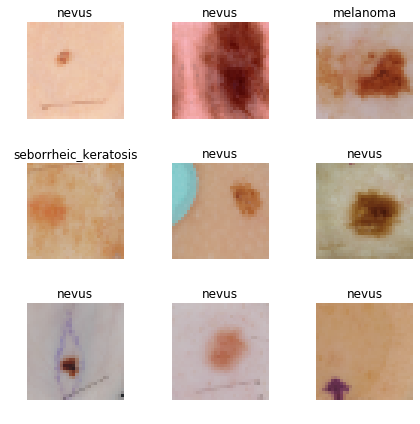

In [9]:
data.show_batch(rows=3, figsize=(6, 6))

## Resnet 34

### Train last layer

In [10]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [11]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.253584,0.897430,0.446667
2,1.053850,1.015292,0.460000


KeyboardInterrupt: 

In [ ]:
learn.save('res34-frozen')

### Results

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses) == len(idxs)

In [ ]:
interp.plot_top_losses(9, figsize=(15, 11))

In [ ]:
interp.plot_confusion_matrix(figsize=(6, 6), dpi=60)

## Unfrozen last layer

In [ ]:
learn.load('res34-frozen')

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

In [ ]:
learn.save('res34-unfrozen')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses) == len(idxs)

In [ ]:
interp.plot_top_losses(9, figsize=(15, 11))

In [ ]:
interp.plot_confusion_matrix(figsize=(6, 6), dpi=60)

## Training: resnet50

In [ ]:
data = (ImageItemList.from_folder(path)
        .random_split_by_pct(0.20)
        .label_from_folder()
        .transform(tfms, size=299)
        .databunch(bs=bs // 2)
        .normalize(imagenet_stats)
       )

In [ ]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8)

In [ ]:
learn.save('res50-frozen')

In [ ]:
learn.load('res50-frozen')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6, 1e-4))

If it doesn't, you can always go back to your previous model.

In [ ]:
learn.save('res50-unfrozen');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix(figsize=(6, 6), dpi=60)
# interp.most_confused(min_val=2)

In [ ]:
interp.plot_top_losses(9, figsize=(15, 11))